<a href="https://colab.research.google.com/github/yuliagrajewska/Computer-Vision-projects/blob/main/histogram_of_oriented_gradients/HOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
import os
from PIL import Image
from pylab import *

In [3]:
#connect to google drive to access files
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
path = '/content/gdrive/MyDrive/cv_a2_data/'

Mounted at /content/gdrive/


**HOG Part** - this section contains all the functions required for the HOG feature extraction, including the convolution function.

In [4]:
#read image, convert to B&W
def read_image(image_name):
  #print(image_name)
  input_image = cv2.imread(image_name)
  #print(input_image.shape)
  input_image = cv2.cvtColor(src=input_image, code=cv2.COLOR_BGR2RGB)
  X,Y,Z = input_image.shape
  output = np.zeros((X,Y))
  for x in range(X):
    for y in range(Y):
      arr = input_image[x][y]
      output[x][y] = np.floor(0.299*arr[0]+0.587*arr[1]+0.114*arr[2])
  return output

In [5]:
#convolution function
def convolve2d(image, kernel):
  sizeX, sizeY = image.shape
  kernel = np.flipud(np.fliplr(kernel))
  stride = 1
  k_sizeX, k_sizeY = kernel.shape
  padding = get_padding_size(k_sizeX)
  padded_img = add_padding(image,padding)

  im_sizeX, im_sizeY = padded_img.shape
  targX,targY = target_size(sizeX, k_sizeX), target_size(sizeY, k_sizeY)
  output = np.zeros((sizeX,sizeY))

  for y in range(0,targY,stride):
    if y > im_sizeY-k_sizeY:
      break

    for x in range(0,targX,stride):
      if x > im_sizeX-k_sizeX:
        break
      res = padded_img[x:x+k_sizeX, y:y+k_sizeY]
      output[x, y] = np.sum(np.multiply(res, kernel))

  return output

def get_padding_size(k_size):
  return k_size//2

def add_padding(image, padding):
  padded_img = np.zeros(shape = (image.shape[0]+padding*2, image.shape[1]+padding*2))
  padded_img[padding:-padding, padding:-padding] = image
  return padded_img

In [6]:
def target_size(img, kernel): #
    n = 0
    # From 0 up to img size
    for i in range(img):
        # + kernel size
        added = i + kernel
        if added <= img:
            n += 1
    return n

In [7]:
#normalization - returns image data between 0 and 255
def normalize_image(image):
  max = np.max(image)
  min = np.min(image)
  image = 255*(image - min)/(max - min) + 0
  return image

In [8]:
from numpy.linalg import norm
#prewitt operator to get x and y image gradients + edge magnitude + gradient angles
def Prewitt(im):
  Px = np.array([[1, 0, -1],
                [1, 0, -1],
                [1, 0, -1]])

  Py = np.array([[1, 1, 1],
                [0, 0, 0],
                [-1, -1, -1]])

  Prewitt_x = convolve2d(im, Px)
  Prewitt_y = convolve2d(im, Py)
  im = np.hypot(Prewitt_x,Prewitt_y)
  im = np.floor(normalize_image(im))
  theta = np.rad2deg(np.arctan2(Prewitt_x,Prewitt_y))

  #converting all the angles to the [-10, 170] range
  theta = np.where(theta < 0, 360+theta,theta)
  theta = np.where(theta >350, 350-theta,theta)
  theta = np.where(theta >170 , theta-180,theta)
  return(im, theta)


In [9]:
#HOG feature computation
def compute_hog(im, theta, cell_size = 8, block_size = 16, block_overlap = 8):
  X,Y = im.shape
  X_cells = int(X/cell_size)
  X_blocks = int(X/block_size)
  X_entries = X_blocks + X_blocks-1
  Y_cells = int(Y/cell_size)
  Y_blocks = int(Y/block_size)
  Y_entries = Y_blocks + Y_blocks-1
  bin_centers = [0,20,40,60,80,100,120,140,160]
  bin_width = 20
  cell_hist = np.zeros((X_cells,Y_cells,9))
  #cell magnitudes
  for x in range(X_cells):
    for y in range(Y_cells):
      bins = np.zeros((9))
      mag = im[8*x:8*x+8,8*y:8*y+8]
      angle = theta[8*x:8*x+8,8*y:8*y+8]

      for i in range(8):
        for j in range(8):
          bin_n = int(np.mod(np.floor(angle[i][j]/bin_width-0.5),9))
          bin_n1 = int(np.mod(bin_n+1,9))
          bins[bin_n] +=mag[i][j]*(bin_centers[bin_n1]-angle[i][j])/bin_width
          bins[bin_n1] +=mag[i][j]*(angle[i][j]-bin_centers[bin_n])/bin_width
      cell_hist[x,y] = bins

  #block normalization:
  block_matrix = []


  #in range X_entries, iterate over cell_hist, cell_hist+1
  for x in range(X_entries):
    for y in range(Y_entries):
      block = np.concatenate((cell_hist[x][y],cell_hist[x+1][y],cell_hist[x][y+1], cell_hist[x+1][y+1]))
      block_norm = block / (np.linalg.norm(block)+0.000001) #the addition is to prevent division by 0

      block_matrix.append(block_norm)
  bl = np.asarray(block_matrix)
  m = bl.flatten()
  #finally, hog feature
  hog = m / np.linalg.norm(m)
  return hog

In [10]:
#function that takes in image name and returns the HOG features
def process_image(image_name):
  im = read_image(image_name)
  im, t = Prewitt(im)
  features = compute_hog(im,t)
  return features


In [11]:
#loading positive test images
t = !ls /content/gdrive/MyDrive/cv_a2_data/Test_Positive
#print(t)
a = "".join(t)
test_pos = a.split('.bmp')
for t in range(len(test_pos)):
  test_pos[t] = test_pos[t].strip()+'.bmp'
test_pos.pop()
print(test_pos)

#in case something here does not work, here's a copy of the list of the image names that can be used instead (replace test_pos with test_pos_backup in the cells below,
#analogous for the next 3 cells)
test_pos_backup = ['crop_000010b.bmp', 'crop001028a.bmp', 'crop001047b.bmp', 'crop001008b.bmp', 'crop001045b.bmp']

['crop_000010b.bmp', 'crop001008b.bmp', 'crop001028a.bmp', 'crop001045b.bmp', 'crop001047b.bmp']


In [12]:
#loading all the test images
t = !ls /content/gdrive/MyDrive/cv_a2_data/Test_Negative
#print(t)
a = "".join(t)
test_neg = a.split('.bmp')
for t in range(len(test_neg)):
  test_neg[t] = test_neg[t].strip()+'.bmp'
test_neg.pop()
print(test_neg)
test_neg_backup = ['00000053a_cut.bmp', 'no_person__no_bike_213_cut.bmp', '00000062a_cut.bmp', 'no_person__no_bike_247_cut.bmp', '00000093a_cut.bmp']

['00000053a_cut.bmp', '00000093a_cut.bmp', 'no_person__no_bike_247_cut.bmp', '00000062a_cut.bmp', 'no_person__no_bike_213_cut.bmp']


In [13]:
#load train positive images
t = !ls /content/gdrive/MyDrive/cv_a2_data/Train_Positive
#print(t)
a = "".join(t)
train_pos = a.split('.bmp')
for t in range(len(train_pos)):
  train_pos[t] = train_pos[t].strip()+'.bmp'
train_pos.pop()
print(train_pos)
train_pos_backup = ['crop001030c.bmp', 'crop001275b.bmp', 'person_and_bike_026a.bmp', 'crop001034b.bmp', 'crop001278a.bmp', 'person_and_bike_151a.bmp', 'crop001063b.bmp', 'crop001500b.bmp', 'crop001070a.bmp', 'crop001672b.bmp']

['crop001030c.bmp', 'crop001063b.bmp', 'crop001275b.bmp', 'crop001500b.bmp', 'person_and_bike_026a.bmp', 'crop001034b.bmp', 'crop001070a.bmp', 'crop001278a.bmp', 'crop001672b.bmp', 'person_and_bike_151a.bmp']


In [14]:
#load train positive images
t = !ls /content/gdrive/MyDrive/cv_a2_data/Train_Negative
#print(t)
a = "".join(t)
train_neg = a.split('.bmp')
for t in range(len(train_neg)):
  train_neg[t] = train_neg[t].strip()+'.bmp'
train_neg.pop()
print(train_neg)
train_neg_backup = ['crop001030c.bmp', 'crop001275b.bmp', 'person_and_bike_026a.bmp', 'crop001034b.bmp', 'crop001278a.bmp', 'person_and_bike_151a.bmp', 'crop001063b.bmp', 'crop001500b.bmp', 'crop001070a.bmp', 'crop001672b.bmp']

['00000003a_cut.bmp', '00000118a_cut.bmp', 'no_person__no_bike_259_cut.bmp', '00000057a_cut.bmp', '01-03e_cut.bmp', 'no_person__no_bike_264_cut.bmp', '00000090a_cut.bmp', 'no_person__no_bike_219_cut.bmp', '00000091a_cut.bmp', 'no_person__no_bike_258_Cut.bmp']


In [15]:
data_list = []
results_list = []
for filename in test_pos:
  f = process_image('/content/gdrive/MyDrive/cv_a2_data/Test_Positive/'+filename)
  data_list.append(f)
  results_list.append(1)

for filename in test_neg:
  f = process_image('/content/gdrive/MyDrive/cv_a2_data/Test_Negative/'+filename)
  data_list.append(f)
  results_list.append(0)

data_test = np.asarray(data_list)
res_test = np.asarray(results_list)

In [16]:
data_list = []
results_list = []
for filename in train_pos:
  f = process_image('/content/gdrive/MyDrive/cv_a2_data/Train_Positive/'+filename)
  data_list.append(f)
  results_list.append(1)

for filename in train_neg:
  f = process_image('/content/gdrive/MyDrive/cv_a2_data/Train_Negative/'+filename)
  data_list.append(f)
  results_list.append(0)

data_train = np.asarray(data_list)
res_train = np.asarray(results_list)

Neural Network Code

In [17]:
# returns the sigmoid value for each value in Z
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

# returns the RELU activation for each value of net input Z
def RELU(Z):
    relu = Z.copy()
    relu[Z<0] = 0
    return relu

# returns the first order derivative of sigmoid at each value in z
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

# returns the first order derivative of RELU at each value in z
def RELU_prime(Z):
    gradient = Z.copy()
    gradient[Z>0] = 1
    gradient[Z<=0] = 0
    return gradient

# returns the mean square error for predicted values 'a'
def mean_square_error(a,y):
    return 1/2 * (np.sum(np.square(y-a))/y.shape[1])

In [18]:
class NeuralNetwork:
    def __init__(self,counts):
        # counts: has count of no of neurons in each layer
        self.no_of_layers = len(counts)
        self.neurons_per_layer = counts
        self.weights=[]
        self.bias = []
        self.activations = []
        # intialising the weights, random initialisation of weights and bias
        for n in range(0,self.no_of_layers-1):
            epsilon = np.sqrt(6)/(np.sqrt(self.neurons_per_layer[n]+self.neurons_per_layer[n+1]))
            self.weights.append((np.random.rand(self.neurons_per_layer[n],self.neurons_per_layer[n+1]))*2*epsilon - epsilon)
            self.bias.append((np.random.rand(self.neurons_per_layer[n+1],1))*2*epsilon - epsilon)

    # feed forward the network, stores the net inputs and activations of each layer while feed forwarding
    def feed_forward(self,x_in):
        self.activations = [x_in]
        net_inputs = [x_in]
        layer = 1
        for w,b in zip(self.weights,self.bias):
            layer += 1
            # calculates the net input to each neuron in the layer - 'layer'
            z = np.transpose(w)@self.activations[-1] + b
            net_inputs.append(z)
            # applying sigmoid for output layer
            if(layer == self.no_of_layers):
                a = sigmoid(z)
            else:
                # Using RELU for hidden layers
                a = RELU(z)
            self.activations.append(a)
        # returns net_inputs and activations of all the layers except input layer
        return (net_inputs,self.activations)

    # this method is same as feed_forward except that this wont store net inputs and activations of hidden layers
    def feed_forward_classify(self,x_in):
        self.activations =x_in
        layer =1
        for w,b in zip(self.weights,self.bias):
            layer+=1
            z = np.transpose(w)@self.activations + b
            if(layer == self.no_of_layers):
                self.activations = sigmoid(z)
            else:
                self.activations = RELU(z)
        return self.activations

    # Back propogation to determine the sensitivities of neurons in each layer
    # sensitivity is nothing but change in ouput error per unit change in net input
    def back_prop(self,net_inputs,observed_out,target_out):
        sensitivities = []
        # s_last : sensitivity of neurons in last layer
        err_last = (observed_out - target_out)
        s_last = err_last * (sigmoid_prime(net_inputs[-1]))
        sensitivities.append(s_last)
        for i in range(self.no_of_layers-2, 0, -1):
            # determines sensitivities of neurons in hidden layers
            s = (self.weights[i]@sensitivities[0]) * RELU_prime(net_inputs[i])
            sensitivities.insert(0,s)
        return sensitivities, err_last

    # x_in - batch of input patterns
    # train_NN update the weights and bias using steepest descent approach
    def train_NN(self, x_in, target_out, lr):
        batch_size = x_in.shape[1]
        (net_inputs,self.activations) = self.feed_forward(x_in)
        sensitivities, err_last = self.back_prop(net_inputs,self.activations[-1],target_out)
        for l in range(0,self.no_of_layers-1):
            # updating weights and biases
            self.weights[l] = self.weights[l] -  ((lr/batch_size) * (self.activations[l]@np.transpose(sensitivities[l])))
            self.bias[l] = self.bias[l] - ((lr/batch_size) * (np.sum(sensitivities[l],axis = 1)[:,np.newaxis]))
        return sensitivities, err_last

    # SGD : stochastic gradient descent
    def SGD(self,input_patterns,target_out,lr,epochs,batch_size,tv_x=None,tv_y=None):
        no_of_patterns = input_patterns.shape[1]
        positions = np.arange(no_of_patterns)
        training_cost = []
        tv_cost=[]
        train_accuracy = []
        tv_accuracy = []
        for e in range(1,epochs+1):
            print("epoch no:", e)
            np.random.shuffle(positions)
            # picking the batch(patterns) in random order given by positions(array of random values)
            for i in range(0,no_of_patterns,batch_size):
                sensitivities, err_last = self.train_NN(input_patterns[:,positions[i:i+batch_size]],target_out[:,positions[i:i+batch_size]],lr)
            print (err_last)

        print()

    # calculates accuracy by comparing the predicted and actual labels
    def accuracy(self,predicted,ts_y):
        y = predicted.copy()
        y[y>=0.5]=1
        y[y<0.5]=0
        total_patterns = y.shape[1]
        count=0
        for i in range(0,total_patterns):
            if(np.array_equal(y[:,i],ts_y[:,i])):
                count+=1
        accuracy = (count/total_patterns) * 100
        return y,accuracy

In [19]:
def train_test_network(train_X,train_Y,test_X,test_Y,neurons):
    # Network Architecture - only one hidden layer
    no_of_features = train_X.shape[0]
    print(no_of_features)
    no_of_neurons_in_hidden_layer = neurons
    no_of_neurns_in_output_layer = 1
    epochs = 300
    lr = 0.009
    batch_size=1
    NN = NeuralNetwork([no_of_features, no_of_neurons_in_hidden_layer, no_of_neurns_in_output_layer])
    print("Training Neural Network for ",epochs," epochs")
    # training the network with train data the above mentioned hyper parameters
    NN.SGD(train_X, train_Y, lr, epochs, batch_size, tv_x = test_X, tv_y = test_Y)
    activations_test = NN.feed_forward_classify(test_X)
    # calculating the test set classification accuracy
    class_labels,accuracy = NN.accuracy(activations_test,test_Y)
    return activations_test,class_labels,accuracy

In [20]:
def print_results(sigmoid_out,class_labels,accuracy_test):
    test_all_path = '/content/gdrive/MyDrive/cv_a2_data/Test_all/'
    print("Test Image",' '*15	,"Output Value", '  Classification' )
    for i in range(0,len(test_image_names)):
        l = len(test_image_names[i])
        img = plt.imread(test_all_path + test_image_names[i])
        plt.figure(i)
        plt.title(test_image_names[i])
        plt.imshow(img, vmin=0, vmax=255)
        # classifying the image as Human if the class label is 0, Not-human otherwise
        if(class_labels[0,i] == 1):
            class_str = 'Human'
        else:
            class_str = 'Not-Human'

        print(test_image_names[i],' '*(30-l),sigmoid_out[0,i], '      ', class_str)
    print()
    print("test set classification accuracy:", accuracy_test)

In [21]:
# path of image sets - train, test
pos_train_path = 'data/Train_Positive'
neg_train_path = 'data/Train_Negative'
pos_test_path = 'data/Test_Positive'
neg_test_path = 'data/Test_Negative'

train_X_pos, image_names_pos_train = data_train[:10], train_pos
train_X_neg, image_names_neg_train = data_train[10:], train_neg
test_X_pos, image_names_pos_test = data_test[:5], test_pos
test_X_neg, image_names_neg_test = data_test[5:], test_neg
print(train_X_pos.shape)

train_X = np.vstack([train_X_pos, train_X_neg]).T
train_Y = np.hstack([np.full((1,train_X_pos.shape[0]),1), np.full((1,train_X_neg.shape[0]),0)])

print(train_X.shape)

test_X = np.vstack([test_X_pos, test_X_neg]).T
test_Y = np.hstack([np.full((1,test_X_pos.shape[0]),1), np.full((1,test_X_neg.shape[0]),0)])

test_image_names = image_names_pos_test + image_names_neg_test
print(test_image_names)


(10, 7524)
(7524, 20)
['crop_000010b.bmp', 'crop001008b.bmp', 'crop001028a.bmp', 'crop001045b.bmp', 'crop001047b.bmp', '00000053a_cut.bmp', '00000093a_cut.bmp', 'no_person__no_bike_247_cut.bmp', '00000062a_cut.bmp', 'no_person__no_bike_213_cut.bmp']


Executing the code for different numbers of neurons

7524
Training Neural Network for  300  epochs
epoch no: 1
[[-0.52445761]]
epoch no: 2
[[-0.52651909]]
epoch no: 3
[[0.47169655]]
epoch no: 4
[[-0.52359048]]
epoch no: 5
[[-0.52255593]]
epoch no: 6
[[0.47193916]]
epoch no: 7
[[-0.52004822]]
epoch no: 8
[[0.47903877]]
epoch no: 9
[[0.47939165]]
epoch no: 10
[[0.48015754]]
epoch no: 11
[[0.47790774]]
epoch no: 12
[[0.48138383]]
epoch no: 13
[[-0.51572956]]
epoch no: 14
[[-0.51783879]]
epoch no: 15
[[0.48342485]]
epoch no: 16
[[0.47684491]]
epoch no: 17
[[0.48212584]]
epoch no: 18
[[0.47935196]]
epoch no: 19
[[-0.50861963]]
epoch no: 20
[[-0.5110972]]
epoch no: 21
[[0.47797185]]
epoch no: 22
[[0.47827726]]
epoch no: 23
[[-0.50927394]]
epoch no: 24
[[0.48114534]]
epoch no: 25
[[0.47983808]]
epoch no: 26
[[-0.50425251]]
epoch no: 27
[[0.48329526]]
epoch no: 28
[[0.48676283]]
epoch no: 29
[[-0.50615654]]
epoch no: 30
[[-0.51112997]]
epoch no: 31
[[0.4796397]]
epoch no: 32
[[-0.50141378]]
epoch no: 33
[[0.48727641]]
epoch no: 34
[[-0.50385172]

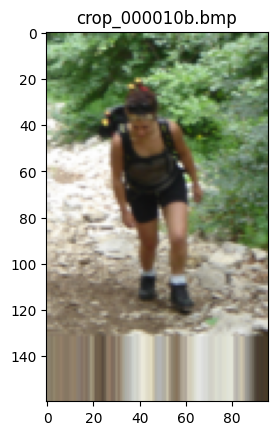

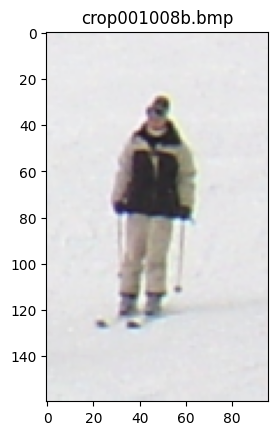

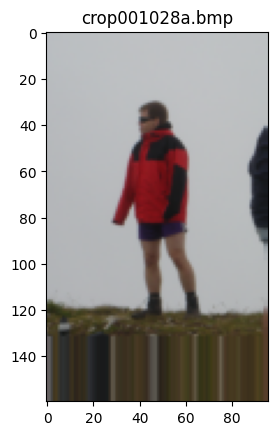

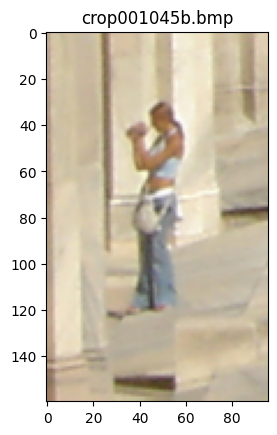

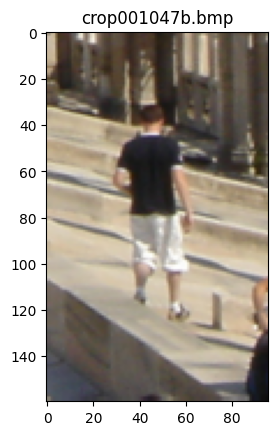

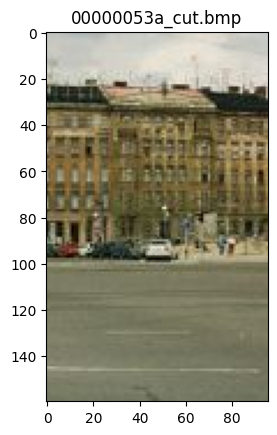

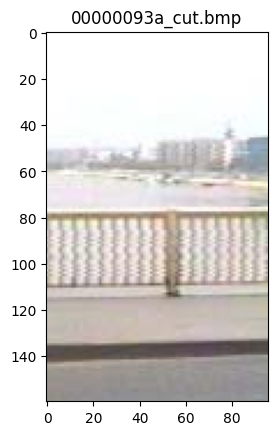

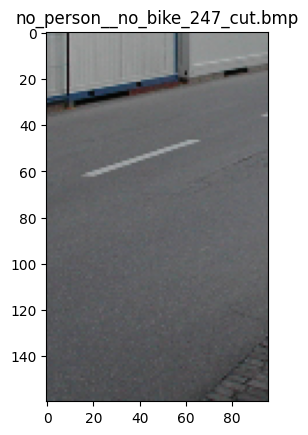

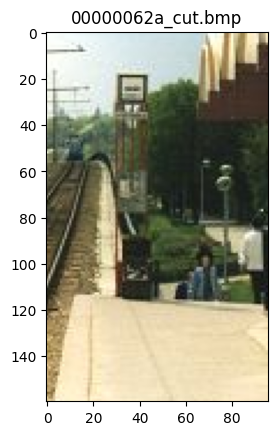

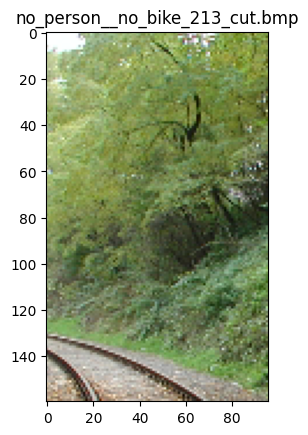

In [22]:
#250 neurons
sigmoid_out, class_labels, accuracy_test = train_test_network(train_X,train_Y,test_X,test_Y,250)
# rounding off activations for display purpose
sigmoid_out = np.round(sigmoid_out,decimals = 3)
print_results(sigmoid_out,class_labels,accuracy_test)

7524
Training Neural Network for  300  epochs
epoch no: 1
[[0.49107363]]
epoch no: 2
[[-0.50902424]]
epoch no: 3
[[0.48585825]]
epoch no: 4
[[-0.51149136]]
epoch no: 5
[[0.48630522]]
epoch no: 6
[[0.49126998]]
epoch no: 7
[[-0.50850853]]
epoch no: 8
[[-0.50650855]]
epoch no: 9
[[-0.50081604]]
epoch no: 10
[[0.49010517]]
epoch no: 11
[[0.49477958]]
epoch no: 12
[[-0.50750119]]
epoch no: 13
[[0.49267618]]
epoch no: 14
[[-0.50653557]]
epoch no: 15
[[-0.5046564]]
epoch no: 16
[[0.49392763]]
epoch no: 17
[[-0.50249621]]
epoch no: 18
[[0.49082735]]
epoch no: 19
[[0.49094591]]
epoch no: 20
[[-0.50368703]]
epoch no: 21
[[-0.50210083]]
epoch no: 22
[[-0.50228921]]
epoch no: 23
[[0.49074422]]
epoch no: 24
[[-0.50222216]]
epoch no: 25
[[-0.49275364]]
epoch no: 26
[[0.49191961]]
epoch no: 27
[[-0.50164676]]
epoch no: 28
[[-0.49912609]]
epoch no: 29
[[0.49391559]]
epoch no: 30
[[0.49023227]]
epoch no: 31
[[0.49077429]]
epoch no: 32
[[0.49398371]]
epoch no: 33
[[-0.49677158]]
epoch no: 34
[[-0.49879

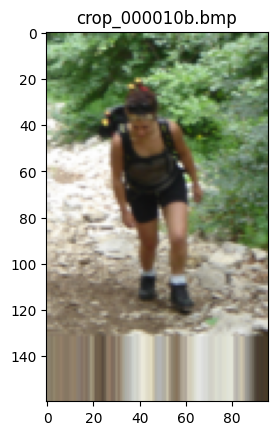

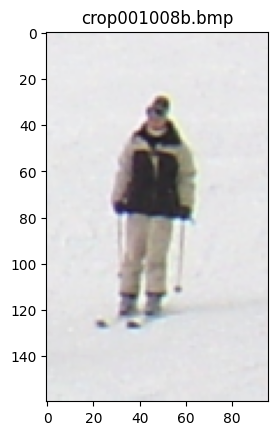

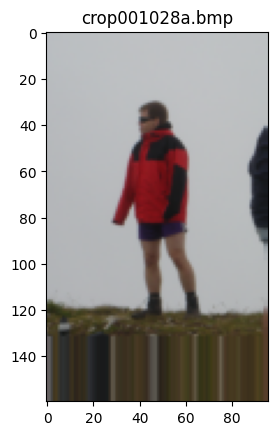

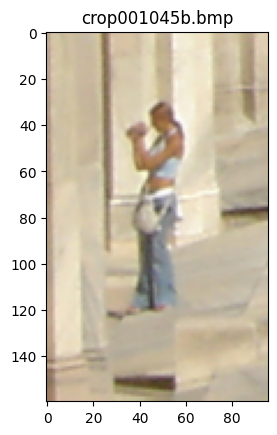

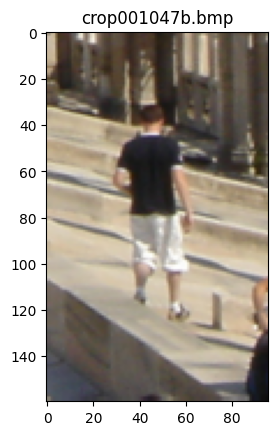

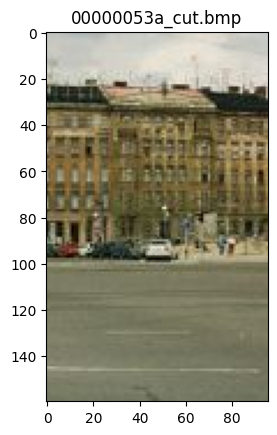

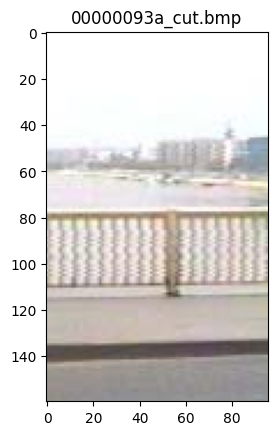

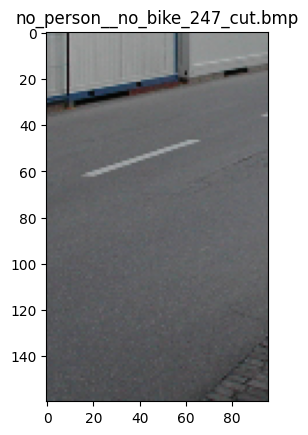

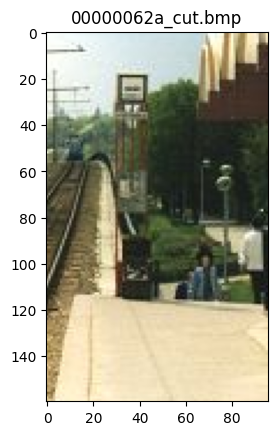

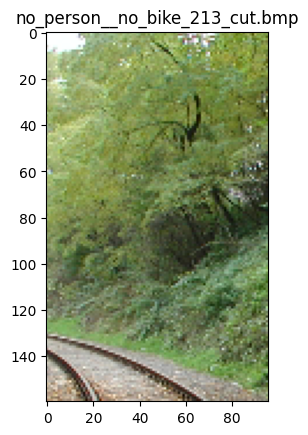

In [23]:
#500 neurons
sigmoid_out, class_labels, accuracy_test = train_test_network(train_X,train_Y,test_X,test_Y,500)
# rounding off activations for display purpose
sigmoid_out = np.round(sigmoid_out,decimals = 3)
print_results(sigmoid_out,class_labels,accuracy_test)

In [ ]:
#1000 neurons
sigmoid_out, class_labels, accuracy_test = train_test_network(train_X,train_Y,test_X,test_Y,1000)
# rounding off activations for display purpose
sigmoid_out = np.round(sigmoid_out,decimals = 3)
print_results(sigmoid_out,class_labels,accuracy_test)

7524
Training Neural Network for  300  epochs
epoch no: 1
[[-0.51675228]]
epoch no: 2
[[0.48720674]]
epoch no: 3
[[-0.51066016]]
epoch no: 4
[[-0.51136639]]
epoch no: 5
[[-0.51352796]]
epoch no: 6
[[0.49193508]]
epoch no: 7
[[-0.50854557]]
epoch no: 8
[[-0.50800547]]
epoch no: 9
[[0.48838681]]
epoch no: 10
[[-0.50791942]]
epoch no: 11
[[-0.50451607]]
epoch no: 12
[[-0.50670262]]
epoch no: 13
[[-0.50602879]]
epoch no: 14
[[0.48910007]]
epoch no: 15
[[-0.5076673]]
epoch no: 16
[[-0.50262953]]
epoch no: 17
[[-0.50114865]]
epoch no: 18
[[-0.50092064]]
epoch no: 19
[[-0.50076291]]
epoch no: 20
[[0.48870718]]
epoch no: 21
[[0.48974837]]
epoch no: 22
[[0.49432209]]
epoch no: 23
[[-0.50152703]]
epoch no: 24
[[-0.50062019]]
epoch no: 25
[[0.48993325]]
epoch no: 26
[[0.48812914]]
epoch no: 27
[[-0.50098276]]
epoch no: 28
[[0.48992798]]
epoch no: 29
[[-0.5028435]]
epoch no: 30
[[0.48763863]]
epoch no: 31
[[0.48955498]]
epoch no: 32
[[0.49273508]]
epoch no: 33
[[-0.49989305]]
epoch no: 34
[[-0.499